## Higher Fidelity Graph States
In this notebook, we will prepare quantum circuits for a 7-qubit graph state and estimate the fidelity through stabilizer measurements using Qiskit. In this example, we use the CTMP method of error mitigation [1] and repeat the graph state measurement 16 times to find statistical error bars.

**To Do:
Modify the graph state preparation circuit or use your own methods of error mitigation to improve the graph state fidelity.**


[1] S. Bravyi, S. Sheldon, A. Kandala, D.C. McKay, J.M. Gambetta, Mitigating measurement errors in multi-qubit experiments, [arXiv:2006.14044](https://arxiv.org/abs/2006.14044) (2020).

## Imports

Begin by importing the necessary packages and defining the functions we will need for the stabilizer measurements.

In [1]:
# Qiskit module
from qiskit import QuantumCircuit
import qiskit.circuit.library as circuit_library
import qiskit.quantum_info as qi
import qiskit.ignis.mitigation as mit

# Qiskit tools for noisy simulation
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.utils import insert_noise

# Qiskit tools for running and monitoring jobs
from qiskit import execute
from qiskit.tools.monitor import job_monitor

# Other imports
import numpy as np

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In order to run the circuits, first load the backend `ibmq_casablanca` from your account using the `IBMQ` provider. You will receive access to `ibm-q-community/ibmquantumawards/open-science` after registering for the Open Science Prize.

In [2]:
# Load IBMQ Account data
from qiskit import IBMQ
IBMQ.load_account()

# Get backend for experiment
provider = IBMQ.get_provider(hub='ibm-q-france', group='univ-montpellier', project='default')
backend = provider.get_backend('ibmq_casablanca')
properties = backend.properties()

## Measurement mitigation

In order to have the data with and without measurement mitigation, we should submit some calibration circuits to perform measurement mitigation afterwards.

In [3]:
num_qubits = backend.configuration().n_qubits
labels = ['0000000', 
          '0000011', 
          '0000101', '0000110', # Added
          '0001001', '0001010', '0001100', 
          '0010001', '0010010', '0010100', '0011000', 
          '0100001', '0100010', '0100100', '0101000', '0110000', 
          '1000001', '1000010', '1000100', '1001000', '1010000', '1100000', 
          '1111111']
meas_cal_circuits, metadata = mit.expval_meas_mitigator_circuits(num_qubits, labels=labels)

## Circuits of interest

We are interested in checking the error we get from several circuits. Here is a description of each.

### Empty circuit

This circuit is here to check the effectiveness of the measurement error mitigation scheme. We are expecting a near-0 error.

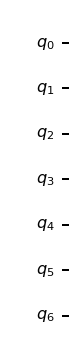

In [4]:
def empty_circuit() -> QuantumCircuit:
    circ = QuantumCircuit(7, name="empty_circuit")
    return circ

circuit = empty_circuit()
circuit.draw(output="mpl")

### Empty circuit with delays

The next circuit of interest is theoretically the same as the first one, but we include some delay in order to let the qubits suffer from decoherence.
The circuit we have right now is $7744$ dt without the measurements, so we will use this as a delay duration.

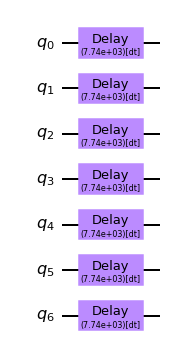

In [5]:
def empty_circuit_delay(delay_dt: int) -> QuantumCircuit:
    circ = QuantumCircuit(7, name="empty_circuit_delayed")
    circ.delay(delay_dt)
    return circ

delay_graph_state = 7744
circuit = empty_circuit_delay(delay_graph_state)
circuit.draw(output="mpl")

### Hadamard initialised circuit

We also want to know what is the impact of decoherence on excited states. As we have a quantum state that is initialised with Hadamard gates, we try this with Hadamard gates at the beginning.

To do so, we first submit a circuit without any delay to have it as a comparison point and then we test the same circuit with delays.

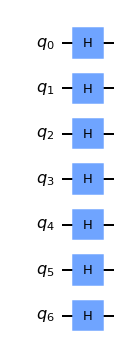

In [6]:
def hadamard_circuit() -> QuantumCircuit:
    circ = QuantumCircuit(7, name="hadamard_initialised")
    circ.h(list(range(7)))
    return circ

circuit = hadamard_circuit()
circuit.draw(output="mpl")

### Hadamard initialised circuit with delay

The Hadamard-initialised circuit, but this time with a delay included.

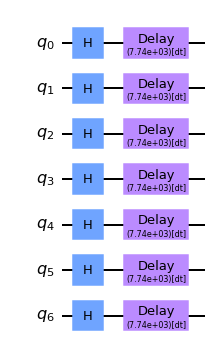

In [7]:
def hadamard_circuit_delay(delay_dt: int) -> QuantumCircuit:
    circ = QuantumCircuit(7, name="hadamard_initialised_delayed")
    circ.h(list(range(7)))
    circ.delay(delay_dt)
    return circ

circuit = hadamard_circuit_delay(delay_graph_state)
circuit.draw(output="mpl")

### Bell-state circuit 

It turns out the graph-state circuit, once simplified, is composed of multiple applications of the well-known circuit that initialise a Bell-state. In order to spot any discrepancies in the error rates of each CNOT, we want to check how precisely we can create a Bell state on each hardware-link.

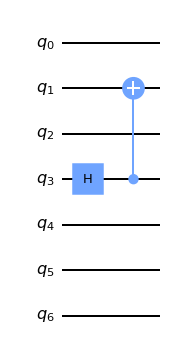

In [8]:
def bell_state_circuit(ctrl: int, trgt: int) -> QuantumCircuit:
    circ = QuantumCircuit(7, name=f"bell_state_circuit_{ctrl}_{trgt}")
    circ.h(ctrl)
    circ.cx(ctrl, trgt)
    return circ

circuit = bell_state_circuit(3, 1)
circuit.draw(output="mpl")

## Execution of the circuits

We first start by executing the measurement error mitigation calibration circuits.

In [9]:
#backend = QasmSimulator.from_backend(provider.get_backend('ibmq_casablanca'))

In [16]:
from osp.hardware import get_native_coupling_map
all_circuits = [
    empty_circuit(), 
    empty_circuit_delay(delay_graph_state), 
    #hadamard_circuit(),
    hadamard_circuit_delay(delay_graph_state)
] + [
    bell_state_circuit(ctrl, trgt)
    for ctrl, trgt in get_native_coupling_map(backend)
]

In [17]:
#job_mit_backend = execute(
#    meas_cal_circuits, 
#    backend, 
#    shots=8192, 
#    initial_layout=[0,1,2,3,4,5,6],
#    job_share_level="hub",
#)
job_mit_backend = backend.retrieve_job("6033b1aed7048739d1e15256")
print(job_mit_backend.job_id())

6033b1aed7048739d1e15256


Then, we execute the other circuits by using quantum tomography. To do so, we have to use the stabilizer formalism and so the first step is to compute the stabilizers of each circuit and construct the circuits that will allow us to do quantum tomography.

In [18]:
def compute_stabilizer_group(circuit):
    """Compute the stabilizer group for stabilizer circuit."""
    state = qi.Statevector.from_instruction(circuit)
    labels = []
    for i in qi.pauli_basis(state.num_qubits):
        val = round(qi.state_fidelity(i.to_matrix()[0], state, validate=False))
        # Why only {-1, 0, 1} are possible values?
        if val != 0:
            label = i.to_labels()[0]
            if val == 1:
                label = '+' + label
            else:
                label = '-' + label
            labels.append(label)
    return labels

def stabilizer_coeff_pauli(stabilizer):
    """Return the 1 or -1 coeff and Pauli label."""
    coeff = 1
    pauli = coeff
    if stabilizer[0] == '-':
        coeff = -1
    if stabilizer[0] in ['+', '-']:
        pauli = stabilizer[1:]
    else:
        pauli = stabilizer
    return coeff, pauli

def stabilizer_measure_circuit(stabilizer, initial_circuit=None):
    """Return a stabilizer measurement circuits.
    
    Args:
        stabilizer (str): a stabilizer string
        initial_circuit (QuantumCircuit): Optional, the initial circuit.
    
    Returns:
        QuantumCircuit: the circuit with stabilizer measurements.
    """
    _, pauli = stabilizer_coeff_pauli(stabilizer)
    if initial_circuit is None:
        circ = QuantumCircuit(len(pauli))
    else:
        circ = initial_circuit.copy()
    for i, s in enumerate(reversed(pauli)):
        if s == 'X':
            circ.h(i)
        if s == 'Y':
            circ.sdg(i)
            circ.h(i)
    circ.measure_all()
    return circ

stabilizer_circuits = list()
stabilizers = list()
for circuit in all_circuits:
    print(f"Computing stabilizers for {circuit.name}.")
    stabilizers.append(compute_stabilizer_group(circuit))
    stabilizer_circuits.append([stabilizer_measure_circuit(stab, circuit) for stab in stabilizers[-1]])
print("Stabilizer computations done!")

Computing stabilizers for empty_circuit.
Computing stabilizers for empty_circuit_delayed.
Computing stabilizers for hadamard_initialised_delayed.
Computing stabilizers for bell_state_circuit_1_2.
Computing stabilizers for bell_state_circuit_6_5.
Computing stabilizers for bell_state_circuit_3_1.
Computing stabilizers for bell_state_circuit_5_3.
Computing stabilizers for bell_state_circuit_5_4.
Computing stabilizers for bell_state_circuit_1_0.
Stabilizer computations done!


In [19]:
stabilizer_jobs = [ 
    #execute(
    #    stab_circuits,
    #    backend, 
    #    shots=8192, 
    #    initial_layout=[0,1,2,3,4,5,6],
    #    job_share_level="hub",
    #)
    #for stab_circuits in stabilizer_circuits
    backend.retrieve_job(job_id) for job_id in [
        "6033b26a7b9375297689a50c",
        "6033b2770e389617701540a8",
        "6033b2950e389622501540aa",
        "6033b2a363e91624a61ea04d",
        "6033b2b41e62935903cf73c4",
        "6033b2c3479d748459805136",
        "6033b2d13d0d1370773248b2",
        "6033b2e13d0d13f06e3248b4",
        "6033b2ef688f36f6db05d29a",
    ]
]
print("\n".join(stab_job.job_id() for stab_job in stabilizer_jobs))

6033b26a7b9375297689a50c
6033b2770e389617701540a8
6033b2950e389622501540aa
6033b2a363e91624a61ea04d
6033b2b41e62935903cf73c4
6033b2c3479d748459805136
6033b2d13d0d1370773248b2
6033b2e13d0d13f06e3248b4
6033b2ef688f36f6db05d29a


## Result post-processing

First create a function to compute the expectation value and the standard deviation of the measurement, either using a mitigator or not using any.

In [20]:
def stabilizer_measure_diagonal(stabilizer):
    """Return the diagonal vector for a stabilizer measurement.
    
    Args:
        stabilizer (str): a stabilizer string
    
    Returns:
        np.ndarray: the diagonal for measurement in the stabilizer basis.
    """
    coeff, pauli = stabilizer_coeff_pauli(stabilizer)
    diag = np.array([1])
    for s in reversed(pauli):
        if s == 'I':
            tmp = np.array([1, 1])
        else:
            tmp = np.array([1, -1])
        diag = np.kron(tmp, diag)
    return coeff * diag
    
def stabilizer_expvals(result, stabilizers, meas_mitigator=None):
    """Compute expectation values from stabilizer measurement results."""

    ### YOUR CODE GOES HERE -- START
    
    expvals = []
    stddevs = []
    for i, stab in enumerate(stabilizers):
        expval, stddev = mit.expectation_value(
            result.get_counts(i),
            diagonal=stabilizer_measure_diagonal(stab),
            meas_mitigator=meas_mitigator)
        expvals.append(expval)
        stddevs.append(stddev)
    return np.array(expvals), np.array(stddevs)

    ### YOUR CODE GOES HERE -- END
    
def stabilizer_fidelity(expvals, stddevs=None):
    """Compute stabilizer state fidelity from stabilizer expvals."""
    mean = np.mean(expvals)
    if stddevs is None:
        return mean
    stddev = np.sqrt(np.sum(stddevs ** 2))
    return mean, stddev

In [21]:
result_mit = job_mit_backend.result()
mitigator_backend = mit.ExpvalMeasMitigatorFitter(result_mit, metadata).fit()

mitigated_results = list()
non_mitigated_results = list()
for stabilizer_job, stabs in zip(stabilizer_jobs, stabilizers):
    result = stabilizer_job.result()
    expvals_nomit, stddevs_nomit = stabilizer_expvals(result, stabs)
    expvals_mit, stddevs_mits = stabilizer_expvals(result, stabs, meas_mitigator=mitigator_backend)
    
    mitigated_results.append(stabilizer_fidelity(expvals_mit, stddevs_mits)[0])
    non_mitigated_results.append(stabilizer_fidelity(expvals_nomit, stddevs_nomit)[0])

for circuit, mit_res, nomit_res in zip(all_circuits, mitigated_results, non_mitigated_results):
    print(f"For circuit {circuit.name}:")
    print(f"\tNon-mitigated: {nomit_res:.3f}")
    print(f"\tMitigated: {mit_res:.3f}")

For circuit empty_circuit:
	Non-mitigated: 0.942
	Mitigated: 1.179
For circuit empty_circuit_delayed:
	Non-mitigated: 0.899
	Mitigated: 1.125
For circuit hadamard_initialised_delayed:
	Non-mitigated: 0.577
	Mitigated: 0.719
For circuit bell_state_circuit_1_2:
	Non-mitigated: 0.902
	Mitigated: 1.133
For circuit bell_state_circuit_6_5:
	Non-mitigated: 0.876
	Mitigated: 1.092
For circuit bell_state_circuit_3_1:
	Non-mitigated: 0.871
	Mitigated: 1.092
For circuit bell_state_circuit_5_3:
	Non-mitigated: 0.876
	Mitigated: 1.089
For circuit bell_state_circuit_5_4:
	Non-mitigated: 0.819
	Mitigated: 1.031
For circuit bell_state_circuit_1_0:
	Non-mitigated: 0.875
	Mitigated: 1.108
